# **Keras**

*Fonctionne avec Python 3.10.9 (Anaconda 23.3.1), Keras 2.10.0, Lime 0.2.0.1 et Shap 0.42.1*

## **Importation des bibliothèques**

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pour les traîtements sur les variables
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Modèle de ML utilisé
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.wrappers.scikit_learn import KerasRegressor
# Si on veut optimiser adam, notamment le learning rate
from keras.optimizers import Adam

# Pour gridsearch
from sklearn import model_selection

# Pour mesures des metrics des résultats
from sklearn import metrics

# Pour mise en forme des résultats
import colorama

# Pour les explications locales
import lime
import lime.lime_tabular

# Pour les explications globale et locales
import shap

# Désactiver un warning DeprecationWarning: KerasRegressor is deprecated
import warnings
warnings.filterwarnings('ignore')

## **Importation du dataset**

In [18]:
dataset_a_utiliser = "data_clean.xlsx"

data = pd.read_excel(dataset_a_utiliser)

## **Fonctions**

In [19]:
def split_and_scale(dataset_name, y_column, features_list, numeric_features, categorical_features, stratification):

    ##############################
    # Split du dataset en X et y #
    ##############################

    global X
    global y

    X = data.loc[:,features_list] # On ajoute nos features dans le X
    y = data.loc[:,y_column] # On ajoute ce qu'on veut prédire dans le y

    #logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
    #y = logtransformer.transform(y)

    ############################
    # Scaling et Encoding de X #
    ############################

    global feature_encoder

    # Ici RobustScaler() améliore un peu les résultats
    numeric_transformer = StandardScaler()

    categorical_transformer = OneHotEncoder(sparse_output=False) # sparse_output=False pour éviter que OneHotEncoder() ne retourne une matrice creuse (sparse, scipy.sparse.csr_matrix)

    feature_encoder = ColumnTransformer(
                transformers=[
                    ('cat', categorical_transformer, categorical_features),    
                    ('num', numeric_transformer, numeric_features)
                    ]
                )
    X = feature_encoder.fit_transform(X)


    ####################################
    # Split de X et y en train et test #
    ####################################

    global X_train
    global X_test
    global y_train
    global y_test

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        random_state=0,
                                                        stratify=eval(stratification))

## **Features**

In [20]:
######################
# Choix des features #
######################

dataset_name = data

# Si rien mettre []
categorical_features = [
                        'BuildingType',
                        'PrimaryPropertyType',
                        'Neighborhood',
                        'ZipCode',
                        #'YearBuilt' # Meilleurs résultats sans
                       ]

# Si rien mettre []
numeric_features = [
                    'NumberofBuildings',
                    'NumberofFloors',
                    'PropertyGFAParking',
                    'PropertyGFABuilding(s)',
                    'Latitude',
                    'Longitude',
                    'gas_prop',
                    'elec_prop',
                    'steam_prop',
                    #'age_bat' # meilleur score sans
                   ]

# Toutes les features
features_list = categorical_features + numeric_features

## ***Keras***



In [21]:
# WN ou nom
EnergyUse = 'SiteEnergyUseWN_kBtu'
#EnergyUse = 'SiteEnergyUse(kBtu)'

# Targets à estimer
targets = [EnergyUse, 'TotalGHGEmissions']

# "y" pour stratifier y, sinon "None"
stratification = "None"

# Afficher les résultats détaillés (True/False)
details = False

for i in targets:

    y_column=i

    print(f"=========== [{i}] ===========")

    # Split & Scale du dataset
    split_and_scale(dataset_name, y_column, features_list, numeric_features, categorical_features, stratification)

    ##################################
    # Création du réseau de neurones #
    ##################################


    def initialize_model():
        

        model = models.Sequential()
    #On indique à notre modèle la dimension des données d'entrées qui correspond au nombre de colonnes de X_train
        model.add(keras.Input(shape=(X_train.shape[1]))) 
    #On met la première couche de notre réseau de neurones. Nous avons une couche avec 140 perceptrons car nous avons
    #140 colonnes dans nos données d'entrée comme dit plus haut. La fonction sigmoid est particulièrement indiquée
    #pour les problèmes de classification. Nous vous encourageons à aller voir à quoi elle ressemble. 
    #    model.add(layers.Dense(86, input_dim=2, activation='sigmoid'))
    #Nous ajoutons une seconde couche car nous sommes dans un problème non linéaire comme dit dans le cours
        model.add(layers.Dense(X_train.shape[1], activation='swish')) #, input_dim=2, activation='sigmoid'
        model.add(layers.Dense(X_train.shape[1], activation='swish'))
        model.add(layers.Dense(X_train.shape[1], activation='swish'))
        model.add(layers.Dense(X_train.shape[1], activation='swish'))
        model.add(layers.Dense(X_train.shape[1], activation='swish'))
        model.add(layers.Dense(X_train.shape[1], activation='swish'))
        model.add(layers.Dense(X_train.shape[1], activation='swish'))
        model.add(layers.Dense(X_train.shape[1], activation='swish'))
        model.add(layers.Dense(X_train.shape[1], activation='swish'))
        model.add(layers.Dense(X_train.shape[1], activation='swish'))
        model.add(layers.Dense(X_train.shape[1], activation='swish'))


        # elu 605
        # relu 609
        # selu 620
        # softplus 603
        # swish 634

        model.add(layers.Dense(1)) #, activation='sigmoid')


        optimizer = Adam(
            learning_rate=0.001,
            decay=0.0,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-09,
            amsgrad=False
        )

        # valeurs par défaut : 
        #'learning_rate': 0.001,
        #'decay': 0.0,
        #'beta_1': 0.9,
        #'beta_2': 0.999,
        #'epsilon': 1e-07,
        # 'amsgrad': False

        
    #Ici, nous pouvons ajouter des paramètres à notre modèle. Il faut juste retenir que "accuracy" permet d'avoir
    #la précision de notre modèle et est particulièrement indiqué pour les problèmes de classification. 
        model.compile(metrics=['mse'],
                    loss='mean_absolute_error',
                    optimizer=optimizer
                    )
        
        return model

    model = initialize_model()

    #"summary" appliqué à notre modèle nous permet d'avoir les paramètres qui la compose ainsi que les dimensions de
    #notre échantillon à la sortie de chaque couche

    #model.summary()

    # Quelques infos supplémentaires sur l'optimiser choisi, notamment le learning_rate
    #model.optimizer.get_config()

    keras.utils.set_random_seed(17)


    model = initialize_model()

    history = model.fit(X_train,
                        y_train, 
                        #epochs = 50,
                        #batch_size = 25,
                        verbose = 0)
    
    y_pred = model.predict(X_test, verbose = 0)

    print("--- Entraînement simple (paramètres par défaut): ---")
    print(f"R² : {colorama.Style.BRIGHT}{colorama.Back.GREEN}{colorama.Fore.BLACK} {metrics.r2_score(y_test, y_pred):.3f} {colorama.Style.RESET_ALL}")
    print(f"RMSE : {metrics.mean_squared_error(y_test, y_pred)**0.5:.4}")
    print(f"MAE : {metrics.mean_absolute_error(y_test, y_pred):.4}")

    print("--- GridSearch : ---")
    model_grid = KerasRegressor(build_fn=initialize_model, verbose=0)

    # Fixer les valeurs des hyperparamètres à tester
    param_grid = {'epochs':[30, 50], 'batch_size':[10, 25]}

    # Déterminer le score qu'on veut optimiser
    score = 'r2'

    # Je le sors ici car je vais réutiliser cette valeur plus tard
    cv = 5

    globals()[f"grid_{i}"] = model_selection.GridSearchCV(
        model_grid, # On indique le modèle à tester
        param_grid,     # hyperparamètres à tester
        cv=cv,           # nombre de folds de validation croisée
        scoring=score   # score à optimiser
    )

    # Optimiser ce modèle sur le jeu d'entraînement
    globals()[f"grid_{i}"].fit(X_train, y_train)


    ###########################
    # Affichage des résultats #
    ###########################

    # Afficher le(s) hyperparamètre(s) optimaux
    best_params = globals()[f"grid_{i}"].best_params_
    print(f"Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (): {best_params}")

    mean = globals()[f"grid_{i}"].cv_results_['mean_test_score'], # score moyen
    std = globals()[f"grid_{i}"].cv_results_['std_test_score'],  # écart-type du score

    print(f"Résultats de la validation croisée : {score} (moyen) : {colorama.Style.BRIGHT}{colorama.Back.YELLOW}{colorama.Fore.BLACK} {mean[0][0]:.03f} {colorama.Style.RESET_ALL} +/-({std[0][0]*2:.03f})")


    y_pred = globals()[f"grid_{i}"].predict(X_test)
    print(f"Score sur le jeu de test ({i}, avec paramètres optimaux) :")
    print(f"R² : {colorama.Style.BRIGHT}{colorama.Back.GREEN}{colorama.Fore.BLACK} {metrics.r2_score(y_test, y_pred):.3f} {colorama.Style.RESET_ALL}")
    print(f"RMSE : {metrics.mean_squared_error(y_test, y_pred)**0.5:.4}")
    print(f"MAE : {metrics.mean_absolute_error(y_test, y_pred):.4}")
    print('_'*80, "\n")


=========== [SiteEnergyUseWN_kBtu] ===========
--- Entraînement simple (paramètres par défaut): ---
R² :  -0.471 
RMSE : 1.23e+07
MAE : 6.962e+06
--- GridSearch : ---
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (): {'batch_size': 25, 'epochs': 30}
Résultats de la validation croisée : r2 (moyen) :  0.639  +/-(0.300)
Score sur le jeu de test (SiteEnergyUseWN_kBtu, avec paramètres optimaux) :
R² :  0.829 
RMSE : 4.191e+06
MAE : 2.443e+06
________________________________________________________________________________ 

=========== [TotalGHGEmissions] ===========
--- Entraînement simple (paramètres par défaut): ---
R² :  -0.045 
RMSE : 300.2
MAE : 121.4
--- GridSearch : ---
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (): {'batch_size': 25, 'epochs': 50}
Résultats de la validation croisée : r2 (moyen) :  0.616  +/-(0.241)
Score sur le jeu de test (TotalGHGEmissions, avec paramètres optimaux) :
R² :  0.774 
RMSE : 139.7
MAE : 56.81
____________________________________

## **Importance locale des features avec LIME**

In [22]:
# Targets dont on veut expliquer les features
targets = [EnergyUse, 'TotalGHGEmissions']

# On choisit combien de features on veut expliquer
nb_features = 10

# On choisit quelle instance on veut tester (ça commence à 0)
instance_a_tester = 0

for i in targets:

    # chaque catégorie est représentée par tous les éléments qu'elle contient, donc je ne peux pas juste prendre features_list
    all_features = list(np.concatenate(feature_encoder.transformers_[0][1].categories_)) + numeric_features

    print(f"=========== [Importance relative locale avec LIME pour {i}] ===========")
    print(f"--- Instance n°{instance_a_tester+1} (nombre d'instances : {len(X_test)}) ---\n") # instance_a_tester+1 car dans le langage courrant on commence à compter à 1

    # Création de l'explainer
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=all_features,
                                                    class_names=[i], verbose=True, mode='regression')

    # Je reprends le même nom dynamique globals()[f"grid_{i}"] que celui utilisé pour définir
    # le nom des modèles de GridsearchCV créés précédemment
    exp = explainer.explain_instance(X_test[instance_a_tester], globals()[f"grid_{i}"].predict, num_features=nb_features)

    exp.show_in_notebook(show_table=False)

    print('_'*80, "\n")

=========== [Importance relative locale avec LIME pour SiteEnergyUseWN_kBtu] ===========
--- Instance n°1 (nombre d'instances : 303) ---

Intercept 89590229.86889406
Prediction_local [5579821.87472863]
Right: 1646739.9


________________________________________________________________________________ 

=========== [Importance relative locale avec LIME pour TotalGHGEmissions] ===========
--- Instance n°1 (nombre d'instances : 303) ---

Intercept 2089.4824545579972
Prediction_local [158.47174098]
Right: 42.191753


________________________________________________________________________________ 



## **Importance globale des features avec SHAP**

On va utiliser shap.KernelExplainer() qui est le mieux adapté pour cet algorithme.<br>
Ne fonctionne pas avec le modèle récupéré via la gridsearch.<br>
Donc je vais réentraîner un modèle en récuprérant les meilleurs hyperparamètres optenu avec le gridsearch.

In [23]:
# initialisation
shap.initjs()

# Je convertis tous les nom des features en STR (certain sont des int), pour éviter les soucis au moment des explications locale
all_features = [str(feature_name) for feature_name in all_features]

## **SiteEnergyUseWN_kBtu**

1/1 [==============================] - 0s 138ms/step


  0%|          | 0/1212 [00:00<?, ?it/s]

65/65 [==============================] - 0s 1ms/step


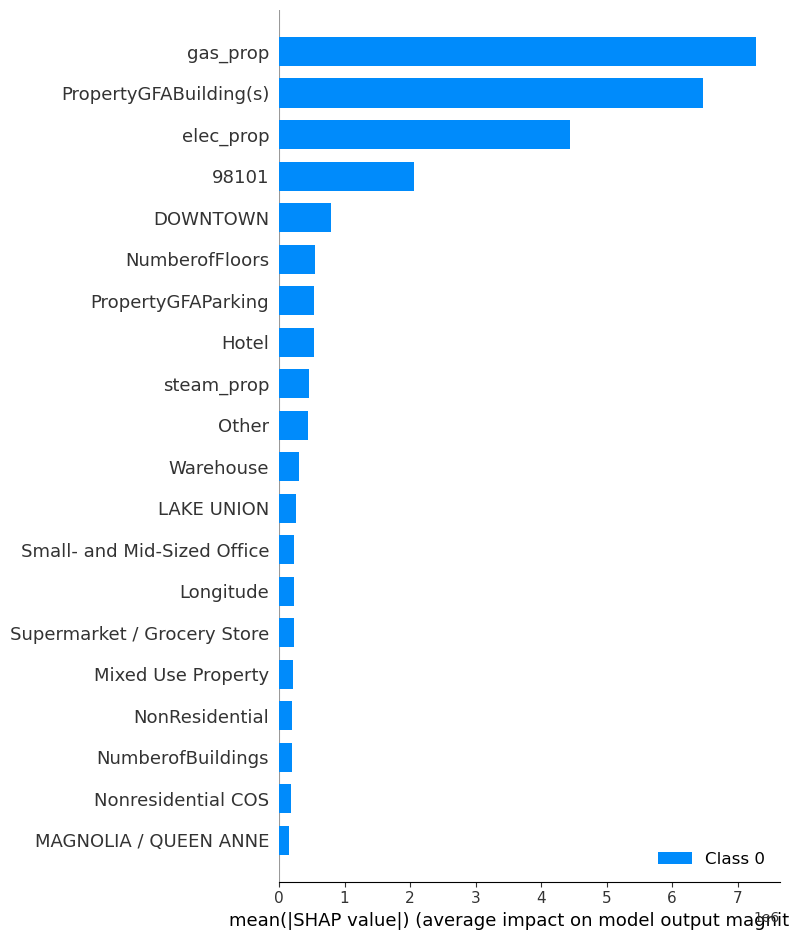

In [24]:
y_column='SiteEnergyUseWN_kBtu'

batch_size = grid_SiteEnergyUseWN_kBtu.best_params_['batch_size']
epochs = grid_SiteEnergyUseWN_kBtu.best_params_['epochs']

split_and_scale(dataset_name, y_column, features_list, numeric_features, categorical_features, stratification)

model_SiteEnergyUseWN_kBtu = initialize_model()

history = model_SiteEnergyUseWN_kBtu.fit(X_train,
                    y_train, 
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 0)

############ SHAP ############

background_summary = shap.sample(X_train, 1)

explainer_grid_SiteEnergyUseWN_kBtu = shap.KernelExplainer(
    model_SiteEnergyUseWN_kBtu.predict, background_summary, feature_names=all_features
)

shap_values_SiteEnergyUseWN_kBtu = explainer_grid_SiteEnergyUseWN_kBtu.shap_values(X_train)


# Graphique représentant l'importance des features au global
shap.summary_plot(
    shap_values_SiteEnergyUseWN_kBtu, X_train, feature_names=all_features, plot_type="bar"
)



## **TotalGHGEmissions**

1/1 [==============================] - 0s 130ms/step


  0%|          | 0/1212 [00:00<?, ?it/s]

65/65 [==============================] - 0s 2ms/step


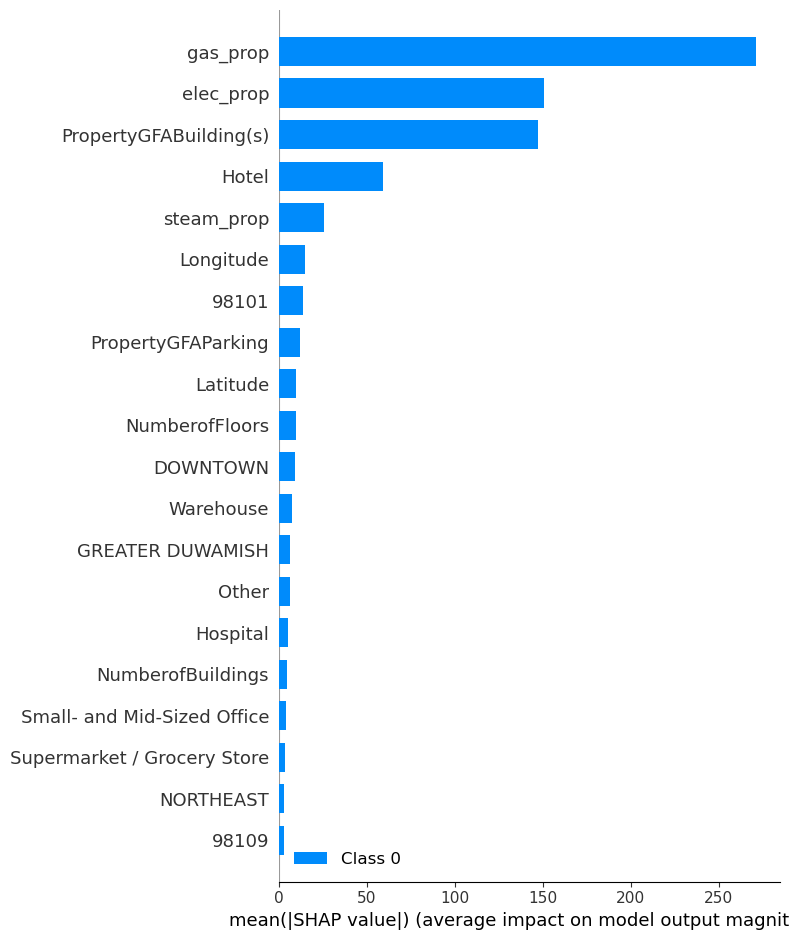

In [25]:
y_column='TotalGHGEmissions'

batch_size = grid_TotalGHGEmissions.best_params_['batch_size']
epochs = grid_TotalGHGEmissions.best_params_['epochs']

split_and_scale(dataset_name, y_column, features_list, numeric_features, categorical_features, stratification)

model_TotalGHGEmissions = initialize_model()

history = model_TotalGHGEmissions.fit(X_train,
                    y_train, 
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 0)

############ SHAP ############

background_summary = shap.sample(X_train, 1)

explainer_grid_TotalGHGEmissions = shap.KernelExplainer(
    model_TotalGHGEmissions.predict, background_summary, feature_names=all_features
)

shap_values_TotalGHGEmissions = explainer_grid_TotalGHGEmissions.shap_values(X_train)


# Graphique représentant l'importance des features au global
shap.summary_plot(
    shap_values_TotalGHGEmissions, X_train, feature_names=all_features, plot_type="bar"
)

